In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd
import urllib3
import urllib.request
import lib
import zipfile
import zipfile2
from zipfile import ZipFile
import time
from urllib.request import urlretrieve, Request, FancyURLopener,urlopen
import os
import os.path
import requests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import re
import glob
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pshah399\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pshah399\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<a id='Index'></a>
### Index

[12.1 Data Downloading and Preparation](#Dataprep)

[12.1 Event Studies](#12.1)

[12.2: Sentiment Analysis](#12.2)

[12.2.1: Rudimentary Sentiment Analysis](#12.2.1)

[12.2.2: Less Rudimentary Sentiment Analysis](#12.2.2)

<a id='Dataprep'></a>
### 12.1: Data Dowloading and preparation
Back to [Index](#Index)

In [4]:
headers = {'Host': 'www.sec.gov', 'Connection': 'close',
         'Accept': 'application/json, text/javascript, */*; q=0.01', 'X-Requested-With': 'XMLHttpRequest',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
         }
for year in range(1995, 2020) :
    qtr = ('QTR1', 'QTR2', 'QTR3', 'QTR4')
    for quarter in qtr:
        url = 'https://www.sec.gov/Archives/edgar/full-index/' + str(year) + '/'+str(quarter)+ '/master' + '.zip'
        req = Request(url, headers=headers) 
        fp = urllib.request.urlopen(req)
        with open('P:/8k_data/master_zipped/' + str(year) + '_' + str(quarter) + '.zip', "wb") as fo:
            fo.write(fp.read())        
        with zipfile2.ZipFile('P:/8k_data/master_zipped/' + str(year) + '_' + str(quarter) + '.zip', 'r') as zip:
            zip.extractall('P:/8k_data/master_unzipped/' + str(year) + '_' + str(quarter))
            
sec = np.empty((0, 5), str)
for year in range(1995, 2020):
    qtr = ('QTR1', 'QTR2', 'QTR3', 'QTR4')
    for quarter in qtr:
        ## year quarter combination
        with open('P:/8k_data/master_unzipped/' + str(year) + '_' + str(quarter) + '/master.idx', encoding='latin-1') as op:
            for i in range(11):
                op.readline()
            myrecords = []
            for line in op:
                    line = line[0:-1]
                    mylist = list(line.split('|'))
                    if (mylist[2] == '8-K'):
                        myrecords.append(mylist)
            final_records = np.array(myrecords)
            ## size 50 random lines
            idx = np.random.randint(np.size(final_records, 0), size = 50)
            sec = np.append(sec, final_records[idx, :], axis = 0)
## save file 
file_output = pd.DataFrame(sec, columns = ['CIK', 'CompanyName', 'FormTypes', 'DATE', 'link'])
#file that keeps track of the company identifier (CIK) and the 8-K filing date 
file_output.to_csv('P:/8k_data/SEC.csv')

Word list from Bill McDonalds Website

In [6]:
word_list = pd.read_csv('P:/8k_data/LoughranMcDonald_MasterDictionary_2020.csv')
word_list[["Positive"]] = word_list[["Positive"]].apply(pd.to_numeric, errors = 'coerce')
word_list[["Negative"]] = word_list[["Negative"]].apply(pd.to_numeric, errors = 'coerce')

comp_path = 'Q:\\Data-ReadOnly\\COMP\\funda.csv'
crsp_path = "Q:\\Data-ReadOnly\\CRSP\\dsf_new.csv"
records_path = 'P:\\8k_data\\records.csv'
sec_path = 'P:/8k_data/SEC.csv'
word_list.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,312,1.422050e-08,1.335201e-08,3.700747e-06,96,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.367356e-10,8.882163e-12,9.362849e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,4.102067e-10,1.200533e-10,5.359747e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,15,6.836779e-10,4.080549e-10,1.406914e-07,14,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8009,3.650384e-07,3.798698e-07,3.523914e-05,1058,0,0,0,0,0,0,0,0,3,12of12inf


Compustat data has CUSIP and CIK both, so we can link SEC datasets with daily returns data

In [7]:
COMP = pd.read_csv(comp_path, header = 0, usecols = ['fyear', 'cusip', 'cik'])
COMP = COMP.rename(columns={'fyear': 'YEAR', 'cusip': 'CUSIP', 'cik' : 'CIK'})
COMP['CUSIP'] = COMP['CUSIP'].str[0:6]
COMP.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,YEAR,CUSIP,CIK
0,1961.0,000032,NaN
1,1962.0,000032,NaN
2,1963.0,000032,NaN
3,1964.0,000032,NaN
4,1965.0,000032,NaN


8k Filling Date of Companies with their CIK and CUSIP

In [8]:
SEC = pd.read_csv(sec_path, header = 0)
SEC = SEC.iloc[:, 1:5]
SEC['filingdate'] = pd.to_datetime(SEC['DATE'], format='%Y/%m/%d')
SEC['YEAR'] = pd.DatetimeIndex(SEC['DATE']).year
SEC[["CIK"]] = SEC[["CIK"]].apply(pd.to_numeric, errors = 'coerce')
COMPSEC = pd.merge(COMP, SEC, how = 'inner', on = ['YEAR', 'CIK'])
COMPSEC = COMPSEC[['CUSIP', 'YEAR', 'CIK', 'CompanyName', 'FormTypes', 'filingdate']].drop_duplicates()
COMPSEC.head()

,CUSIP,YEAR,CIK,CompanyName,FormTypes,filingdate
0,000361,2010.0,1750.0,AAR CORP,8-K,2010-06-10
2,000886,2007.0,61478.0,ADC TELECOMMUNICATIONS INC,8-K,2007-10-23
4,02376R,2001.0,6201.0,AMR CORP,8-K,2001-06-26
5,723484,2013.0,764622.0,PINNACLE WEST CAPITAL CORP,8-K,2013-04-09
7,723484,2017.0,764622.0,PINNACLE WEST CAPITAL CORP,8-K,2017-03-01


Daily Data Return_data

In [9]:
Return_data = pd.read_csv(crsp_path, usecols = ['CUSIP','DATE', 'PRC', 'SHROUT', 'RET', 'VWRETD', 'VOL'])
Return_data['CUSIP'] = Return_data['CUSIP'].str[0:6]
Return_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DATE,CUSIP,PRC,VOL,RET,SHROUT,VWRETD
0,19860106,683916,NaN,NaN,NaN,NaN,-0.000138
1,19860107,683916,-2.5625,1000.0,C,3680.0,0.013809
2,19860108,683916,-2.5000,12800.0,-0.024390,3680.0,-0.020744
3,19860109,683916,-2.5000,1400.0,0.000000,3680.0,-0.011219
4,19860110,683916,-2.5000,8500.0,0.000000,3680.0,0.000083


In [10]:
cols = Return_data.columns.drop(['CUSIP', 'DATE'])
Return_data[cols] = Return_data[cols].apply(pd.to_numeric, errors='coerce')
Return_data['DATE'] = Return_data['DATE'].apply(str)
Return_data['DATE'] = pd.to_datetime(Return_data['DATE'])
Return_data['YEAR'] = pd.DatetimeIndex(Return_data['DATE']).year
Return_data['YEAR_LAG'] = Return_data['YEAR'] - 1

COMPSEC['YEAR'] = COMPSEC['YEAR'].astype(int)
Return_data['YEAR'] = Return_data['YEAR'].astype(int)
combined_Data = pd.merge(Return_data, COMPSEC, how = 'inner', left_on = ['CUSIP', 'YEAR'], right_on = ['CUSIP', 'YEAR'])
combined_Data.to_csv("P:/8k_data/combined_Data.csv")

In [11]:
DATA = pd.read_csv("P:/8k_data/combined_Data.csv")
DATA = DATA.iloc[:, 1:]
CHECK = [(DATA['DATE'] == DATA['filingdate']), (DATA['DATE'] != DATA['filingdate'])]
DATA['filing_checker'] = np.select(CHECK, [1,0])
DATA["RET"] = DATA["RET"].apply(pd.to_numeric, errors = 'coerce')
DATA.dropna()
DATA['turnover'] = DATA['VOL']/DATA['SHROUT']
DATA['adjust'] = (np.log(DATA['turnover'] + (2.55 * (10 ** (-6)))))
DATA['regression'] = (DATA.groupby('CUSIP')['adjust'].shift(-11).rolling(60, min_periods = 1).sum())/60
DATA['val'] = np.power((DATA['adjust'] - DATA['regression']), 2)
DATA['std'] = DATA.groupby('CUSIP')['val'].shift(-11).rolling(60, min_periods = 1).sum()
DATA['adj_std'] = np.sqrt(DATA['std']/60)
DATA['ATO'] = ((DATA['adjust'] - DATA['regression'])/(DATA['adj_std']))
DATA.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DATE,CUSIP,PRC,VOL,RET,SHROUT,VWRETD,YEAR,YEAR_LAG,CIK,...,FormTypes,filingdate,filing_checker,turnover,adjust,regression,val,std,adj_std,ATO
0,1995-01-03,NaN,16.25,11140.0,0.0,5721.0,-0.00241,1995,1994,2969.0,...,8-K,1995-01-20,0,1.947212,0.6664,NaN,NaN,NaN,NaN,NaN
1,1995-01-03,NaN,16.25,11140.0,0.0,5721.0,-0.00241,1995,1994,41147.0,...,8-K,1995-01-31,0,1.947212,0.6664,NaN,NaN,NaN,NaN,NaN
2,1995-01-03,NaN,16.25,11140.0,0.0,5721.0,-0.00241,1995,1994,710597.0,...,8-K,1995-12-18,0,1.947212,0.6664,NaN,NaN,NaN,NaN,NaN
3,1995-01-03,NaN,16.25,11140.0,0.0,5721.0,-0.00241,1995,1994,63416.0,...,8-K,1995-08-21,0,1.947212,0.6664,NaN,NaN,NaN,NaN,NaN
4,1995-01-03,NaN,16.25,11140.0,0.0,5721.0,-0.00241,1995,1994,722573.0,...,8-K,1995-02-15,0,1.947212,0.6664,NaN,NaN,NaN,NaN,NaN


In [12]:
def foo(df, a,  b):
    return sm.OLS(df[b], df[a]).fit().predict()
xlist = DATA.groupby('CUSIP').apply(foo, 'VWRETD', 'RET')
xlist = pd.DataFrame(xlist)
final_list = xlist.iloc[:, 0:1]
final_list = final_list.reset_index()
final_list = final_list.iloc[:, 0:1]
final_list.set_axis(['CUSIP'], axis = 1,inplace = True)
counter = final_list['CUSIP'].count()

<a id='12.1'></a>
### 12.1: Event Studies
Back to [Index](#Index)

In [13]:
index_list = list(xlist.index)
value = pd.DataFrame(np.concatenate(np.array(xlist).tolist()))   
alpha = value.iloc[0:counter, 0:1]
alpha['CUSIP'] = index_list
alpha = alpha.rename(columns={alpha.columns[0]: 'ALPHA'})
beta = value.iloc[counter:2*counter, 0:1]
beta['CUSIP'] = index_list
beta = beta.rename(columns={beta.columns[0]: 'BETA'})
theta = pd.merge(alpha, beta, how = 'inner', on = ['CUSIP'])
TOTAL = pd.merge(DATA, theta, how = 'inner', on = 'CUSIP')

TOTAL.head()

,DATE,CUSIP,PRC,VOL,RET,SHROUT,VWRETD,YEAR,YEAR_LAG,CIK,...,filing_checker,turnover,adjust,regression,val,std,adj_std,ATO,ALPHA,BETA
0,2018-01-02,729132,61.080,98617.0,0.005929,33607.0,0.008496,2018,2017,785786.0,...,0,2.934418,1.076510,0.049947,1.053832,7.041573,0.342578,2.996585,-0.013904,0.000788
1,2018-01-03,729132,61.160,88820.0,0.001310,33607.0,0.005866,2018,2017,785786.0,...,0,2.642902,0.971878,0.081652,0.792502,9.368120,0.395140,2.252940,-0.013904,0.000788
2,2018-01-04,729132,61.910,96068.0,0.012263,33607.0,0.004005,2018,2017,785786.0,...,0,2.858571,1.050323,0.111911,0.880616,11.341756,0.434775,2.158384,-0.013904,0.000788
3,2018-01-05,729132,62.215,67161.0,0.004927,33607.0,0.005816,2018,2017,785786.0,...,0,1.998423,0.692360,0.139612,0.305530,12.847156,0.462730,1.194535,-0.013904,0.000788
4,2018-01-08,729132,65.120,230817.0,0.046693,33607.0,0.001822,2018,2017,785786.0,...,0,6.868123,1.926891,0.168294,3.092665,14.434662,0.490487,3.585409,-0.013904,0.000788


In [14]:
TOTAL = TOTAL.dropna()
## Calculating Abnormal returns
TOTAL['AR'] = TOTAL['RET'] - (TOTAL['ALPHA'] + TOTAL['BETA'] * TOTAL['VWRETD'])
## CAR0 is simply AR
TOTAL['CAR0'] = TOTAL['AR']
## CAR1 is +/-1 day centered aroung filling date
TOTAL['CAR1'] = TOTAL.groupby(['CUSIP'])['AR'].shift(1).rolling(3, min_periods = 1).sum().shift(-1)
TOTAL['CAR2'] = TOTAL.groupby(['CUSIP'])['AR'].shift(2).rolling(5, min_periods = 1).sum().shift(-2)
TOTAL['CAR3'] = TOTAL.groupby(['CUSIP'])['AR'].shift(3).rolling(7, min_periods = 1).sum().shift(-3)
TOTAL['CAR5'] = TOTAL.groupby(['CUSIP'])['AR'].shift(5).rolling(11, min_periods = 1).sum().shift(-5)
TOTAL = TOTAL.loc[TOTAL['filing_checker'] == 1]
CAR = TOTAL[['CIK'] + ['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
CAR.to_csv(("P:/8k_data/CAR.csv"))
CAR[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']].describe()

,ATO,CAR0,CAR1,CAR2,CAR3,CAR5
count,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000
mean,0.453408,-0.001725,-0.002960,-0.001682,-0.002135,0.000221
std,1.190342,0.053029,0.090100,0.124118,0.152190,0.205021
min,-6.216906,-0.608473,-0.951079,-0.579308,-0.742702,-1.185558
25%,-0.303583,-0.020571,-0.043136,-0.059559,-0.077346,-0.101873
50%,0.404547,-0.001185,-0.000330,-0.001358,-0.000699,-0.002357
75%,1.143917,0.018676,0.040080,0.060623,0.072156,0.098368
max,5.961652,0.282731,0.405881,1.598387,1.648797,1.647928


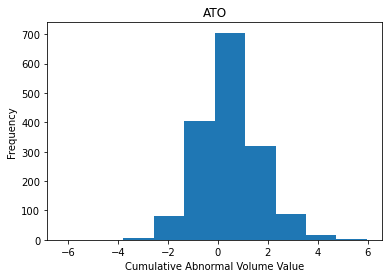

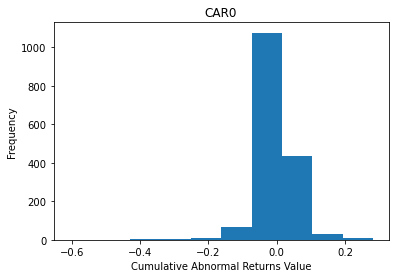

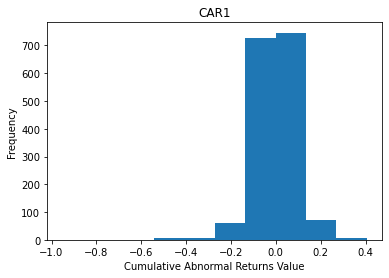

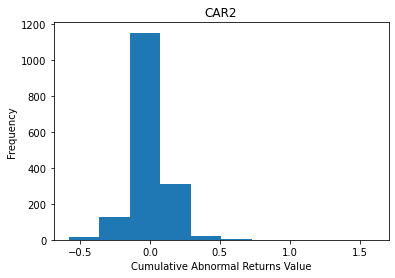

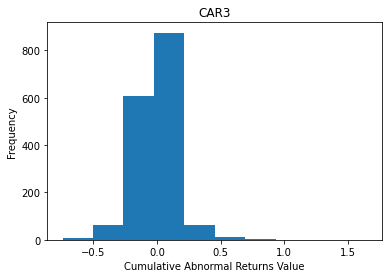

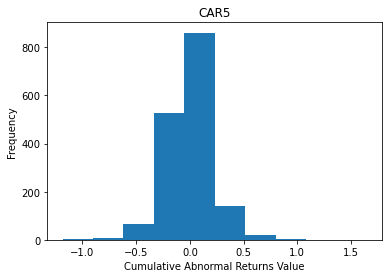

In [15]:
ATOplot = CAR['ATO'].plot.hist()
plt.xlabel('Cumulative Abnormal Volume Value')
plt.title('ATO')
plt.show()
CAR0plot = CAR['CAR0'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR0')
plt.show()
CAR1plot = CAR['CAR1'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR1')
plt.show()
CAR2plot = CAR['CAR2'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR2')
plt.show()
CAR3plot = CAR['CAR3'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR3')
plt.show()
CAR5plot = CAR['CAR5'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR5')
plt.show()

<a id='12.2'></a>
### 12.2: Sentiment Analysis
Back to [Index](#Index)

In [16]:
SEC = pd.read_csv('P:/8k_data/SEC.csv')
SEC_DATA = SEC.iloc[:, 1:]
combined_Data = pd.read_csv('P:/8k_data/combined_Data.csv')
combined_Data = combined_Data['CIK']
combined_Data = combined_Data.drop_duplicates()
new_Combined = pd.merge(combined_Data, SEC_DATA, how = 'inner', on = 'CIK')
myfiles = list(new_Combined.iloc[:, 4])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
## Time consuming step

In [18]:
for file in myfiles:
    url = 'https://www.sec.gov/Archives/' + file
    a_list = list(file.split('/'))
    req = Request(url, headers=headers) 
    fp = urllib.request.urlopen(req)
    with open('P:/8k_data/' + a_list[2] + '_' + a_list[3], "wb") as fo:
        fo.write(fp.read())   

### Rudimentary sentiment Analysis
### Function to calculate difference of negative and positive words in each 8k file.

<a id='12.2.1'></a>
Back to [Index](#Index)

In [19]:
def scoring(pos, neg, listfiles):
    tonelist = []
    for file in listfiles:
        with open(file) as myfile:
            txt = myfile.read()
            txt = txt.upper()
            word_checker = r"(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+"
            txt = re.findall(word_checker, txt)
            pos_score = 0
            neg_score = 0
            for word in pos:
                pos_score += txt.count(word)
            for word in neg:
                neg_score += txt.count(word)
            tone = (pos_score - neg_score)/len(txt)
            tonelist.append((file, tone))
    tone_data = pd.DataFrame(tonelist)
    tone_data = tone_data.set_axis(['File', 'Tone_score'], axis = 1,inplace = False)
    return tone_data

negatives = set(word_list[word_list['Negative'] != 0]['Word'])
positives = set(word_list[word_list['Positive'] != 0]['Word'])
file_8k = glob.glob("P:/8k_data/*.txt")
word_listfile = scoring(positives, negatives, file_8k)
word_listfile.to_csv(("P:/8k_data/word_listfile.csv"))

In [20]:
new_Combined['link'] = new_Combined['link'].str[-24:]
new_Combined = new_Combined.rename(columns={"link": 'File'})
new_Combined.head()

,CIK,CompanyName,FormTypes,DATE,File
0,2969.0,AIR PRODUCTS & CHEMICALS INC /DE/,8-K,1995-01-20,0000950123-95-000080.txt
1,2969.0,AIR PRODUCTS & CHEMICALS INC /DE/,8-K,2003-04-24,0000950123-03-004660.txt
2,2969.0,AIR PRODUCTS & CHEMICALS INC /DE/,8-K,2005-07-27,0000950123-05-008953.txt
3,2969.0,AIR PRODUCTS & CHEMICALS INC /DE/,8-K,2006-03-22,0001299933-06-002134.txt
4,41147.0,GERIATRIC & MEDICAL COMPANIES INC,8-K,1995-01-31,0000041147-95-000006.txt


In [21]:
word_list = pd.read_csv("P:/8k_data/word_listfile.csv", header = 0)
new_word_list = word_list.iloc[:, 1:]
new_word_list['File'] = new_word_list['File'].str[-24:]
new_word_list

,File,Tone_score
0,0000950123-95-000080.txt,0.012009
1,0000950123-03-004660.txt,0.001550
2,0000950123-05-008953.txt,0.001130
3,0001299933-06-002134.txt,0.001812
4,0000041147-95-000006.txt,0.000000
...,...,...
2492,0001482512-19-000058.txt,0.004115
2493,0001108827-13-000015.txt,-0.003044
2494,0001104659-12-085744.txt,-0.003398
2495,0001104659-19-021962.txt,-0.007913


In [28]:
total_word_list = pd.merge(new_word_list, new_Combined, how = 'inner', on = 'File')
finalword = pd.merge(CAR, total_word_list, how = 'inner', on = 'CIK')
finalword.head()

,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,File,Tone_score,CompanyName,FormTypes,DATE
0,785786.0,0.943245,0.008523,0.049675,0.064560,0.093039,0.188589,0000785786-18-000034.txt,-0.007669,PLEXUS CORP,8-K,2018-06-18
1,789019.0,0.112075,0.026013,0.074759,0.121795,0.159056,0.214954,0001193125-14-314623.txt,0.001538,MICROSOFT CORP,8-K,2014-08-19
2,773840.0,0.368452,0.015600,0.065531,0.105240,0.150502,0.245474,0000773840-96-000018.txt,0.000000,ALLIEDSIGNAL INC,8-K,1996-11-26
3,9346.0,0.849921,-0.019029,-0.046526,-0.075466,-0.101151,-0.150401,0000009346-19-000086.txt,0.001748,Protective Insurance Corp,8-K,2019-09-16
4,9346.0,0.546220,-0.013126,-0.055759,-0.069435,-0.122212,-0.160192,0000009346-19-000086.txt,0.001748,Protective Insurance Corp,8-K,2019-09-16


Quintile 0 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  502.000000  502.000000  502.000000  502.000000  502.000000  502.000000
mean     0.394442   -0.002999   -0.006365   -0.006154   -0.010678   -0.012714
std      1.222988    0.055094    0.095133    0.128095    0.159406    0.221646
min     -6.216906   -0.412782   -0.581957   -0.579308   -0.646712   -1.185558
25%     -0.330191   -0.022808   -0.043278   -0.067925   -0.082786   -0.116912
50%      0.275122   -0.000796   -0.002247    0.003758    0.003283   -0.001646
75%      0.999990    0.018010    0.040240    0.063511    0.071193    0.098584
max      4.990260    0.214359    0.344932    0.654366    0.744943    0.933842


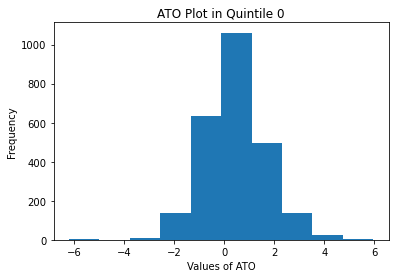

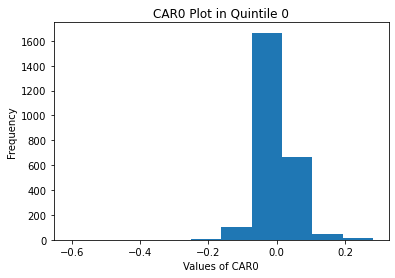

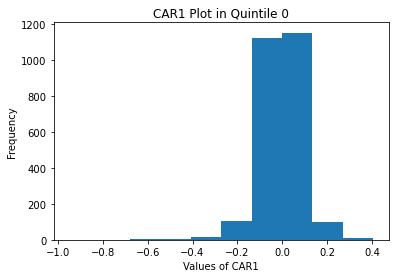

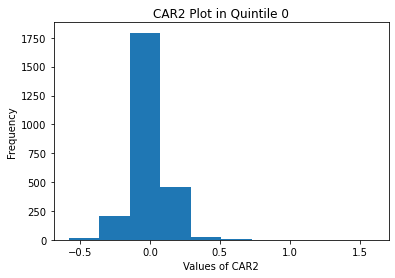

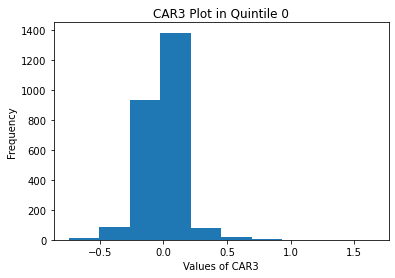

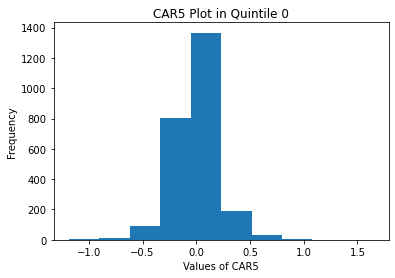

Quintile 1 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  502.000000  502.000000  502.000000  502.000000  502.000000  502.000000
mean     0.433515   -0.005929   -0.005327   -0.006588   -0.006649   -0.001857
std      1.204962    0.048623    0.087376    0.110694    0.133847    0.182350
min     -2.588056   -0.445003   -0.581957   -0.579308   -0.588953   -0.655776
25%     -0.319523   -0.021696   -0.042898   -0.058075   -0.071631   -0.089113
50%      0.367777   -0.003534   -0.001662   -0.004048   -0.004677   -0.004037
75%      1.111742    0.015224    0.039333    0.051824    0.066259    0.097301
max      5.961652    0.205504    0.336724    0.336712    0.486105    0.680826


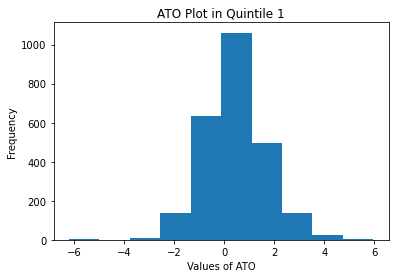

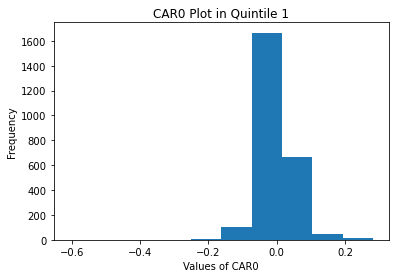

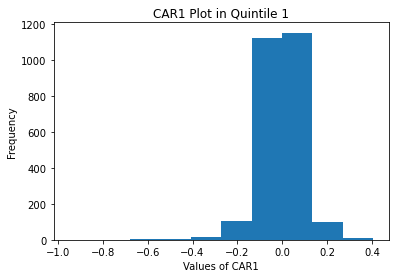

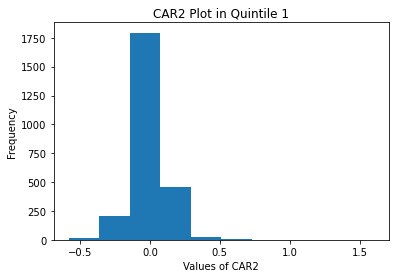

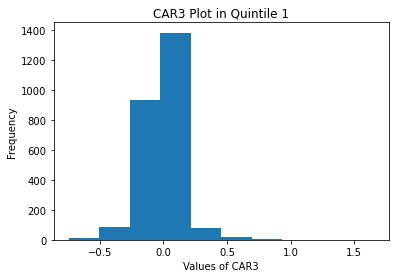

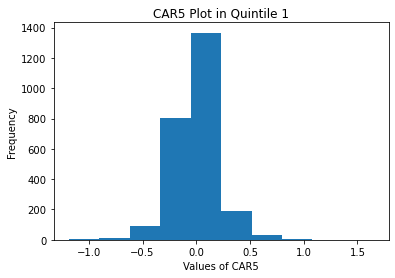

Quintile 2 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  639.000000  639.000000  639.000000  639.000000  639.000000  639.000000
mean     0.516017   -0.002163   -0.006458   -0.009349   -0.012772   -0.012203
std      1.160912    0.050691    0.077686    0.104942    0.134804    0.185456
min     -4.022694   -0.608473   -0.467188   -0.498108   -0.742702   -0.912755
25%     -0.251364   -0.019308   -0.042937   -0.065254   -0.079077   -0.104971
50%      0.494742   -0.002799   -0.002233   -0.006778   -0.008046   -0.007919
75%      1.225272    0.016696    0.034529    0.051936    0.060529    0.081296
max      4.141663    0.210207    0.227046    0.361834    0.723056    0.701030


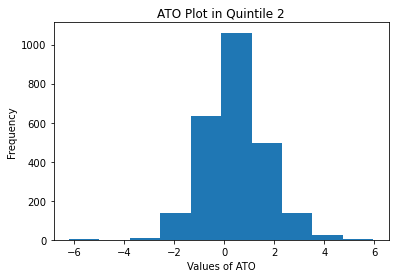

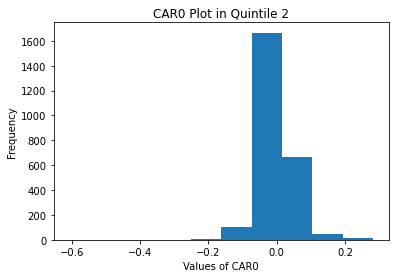

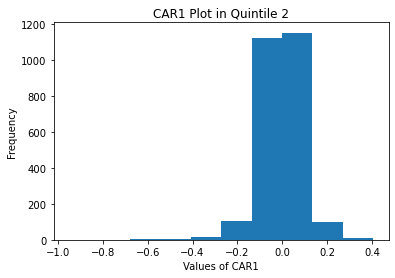

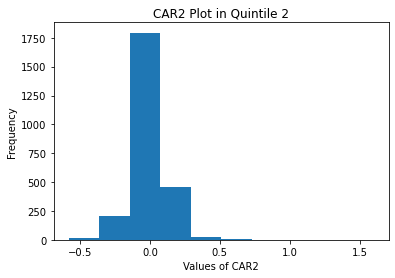

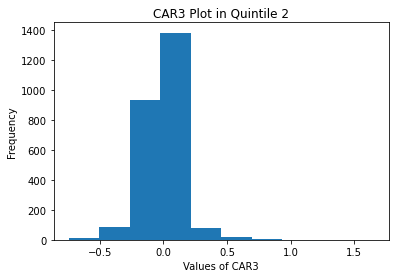

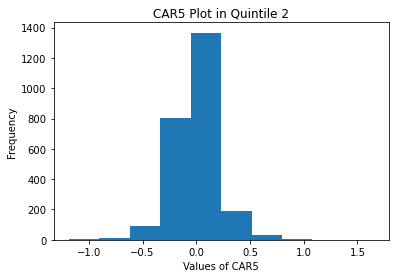

Quintile 3 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000
mean     0.515079    0.003653    0.004172    0.011220    0.015429    0.016899
std      1.241766    0.040392    0.080487    0.133005    0.155192    0.207060
min     -3.290335   -0.155991   -0.265556   -0.310659   -0.341774   -0.602282
25%     -0.336318   -0.014670   -0.036265   -0.051254   -0.058944   -0.081679
50%      0.476157    0.002525    0.001130    0.007854    0.003776    0.008386
75%      1.327858    0.021480    0.037690    0.059949    0.078063    0.088973
max      4.209357    0.282731    0.405881    1.598387    1.648797    1.647928


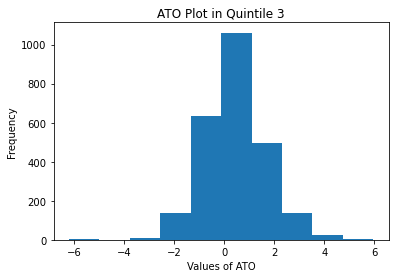

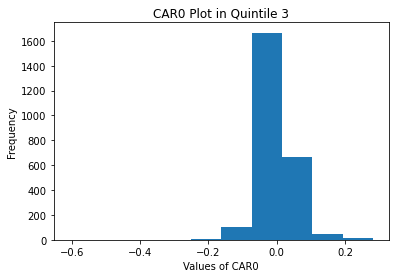

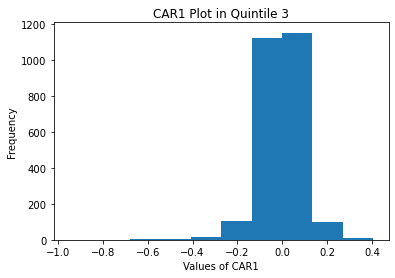

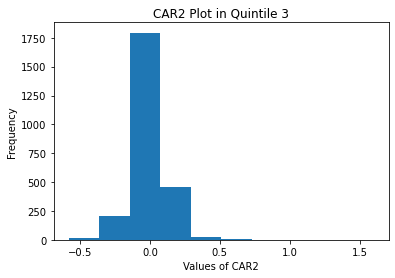

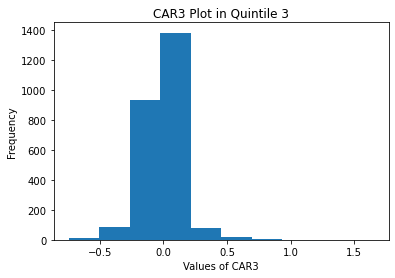

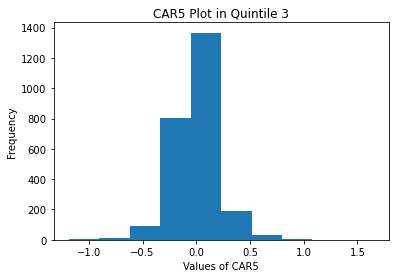

Quintile 4 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  502.000000  502.000000  502.000000  502.000000  502.000000  502.000000
mean     0.366498    0.000511   -0.002109   -0.000637    0.001818    0.002088
std      1.143100    0.048320    0.093207    0.117952    0.148520    0.204029
min     -6.216906   -0.294641   -0.951079   -0.424129   -0.646712   -0.912755
25%     -0.404566   -0.021933   -0.042939   -0.058824   -0.073145   -0.095932
50%      0.339795   -0.000464    0.000569    0.001214    0.002514    0.002450
75%      1.082981    0.019885    0.040581    0.066026    0.072823    0.097474
max      4.045667    0.239341    0.344932    0.654793    0.773146    0.916050


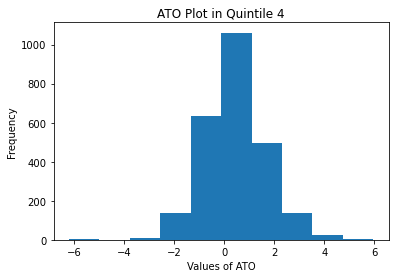

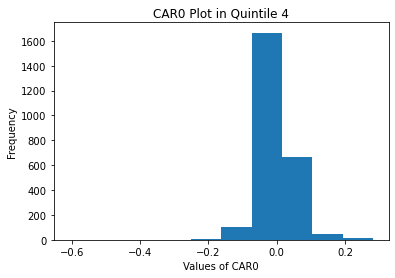

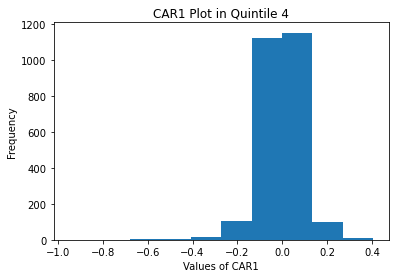

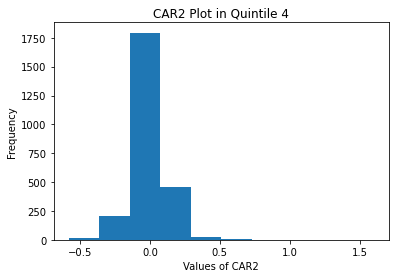

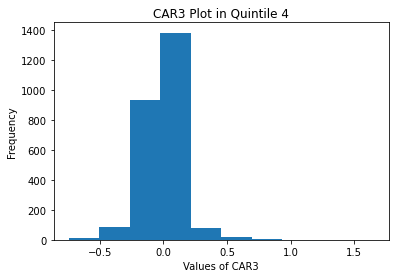

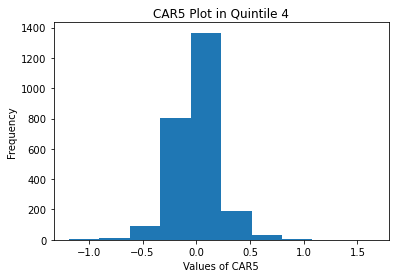

In [29]:
finalword['QUINTILE'] = pd.qcut(finalword['Tone_score'], q=5, labels = False)
## we divide the score of diff between pos and negative words and cut the observations into quintiles

finalword.to_csv(("P:/8k_data/finalword.csv"))
vlist = ['ATO', 'CAR0', 'CAR1', 'CAR2', 'CAR3', 'CAR5']
for i in range (0, 5):
    val = finalword.loc[finalword['QUINTILE'] == i]
    print('Quintile', i, 'Descriptive Stats: ')
    describeval = val[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
    print(describeval.describe())
    for j in vlist:
        plot = finalword[j].plot.hist()
        plt.xlabel('Values of ' + str(j))
        plt.title(str(j) + ' Plot in Quintile ' + str(i))
        plt.show()

In [30]:
finalword = pd.read_csv("P:/8k_data/finalword.csv")
new_finalword = finalword.iloc[:, 1:]
new_finalword.head()

,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,File,Tone_score,CompanyName,FormTypes,DATE,QUINTILE
0,785786.0,0.943245,0.008523,0.049675,0.064560,0.093039,0.188589,0000785786-18-000034.txt,-0.007669,PLEXUS CORP,8-K,2018-06-18,0
1,789019.0,0.112075,0.026013,0.074759,0.121795,0.159056,0.214954,0001193125-14-314623.txt,0.001538,MICROSOFT CORP,8-K,2014-08-19,4
2,773840.0,0.368452,0.015600,0.065531,0.105240,0.150502,0.245474,0000773840-96-000018.txt,0.000000,ALLIEDSIGNAL INC,8-K,1996-11-26,2
3,9346.0,0.849921,-0.019029,-0.046526,-0.075466,-0.101151,-0.150401,0000009346-19-000086.txt,0.001748,Protective Insurance Corp,8-K,2019-09-16,4
4,9346.0,0.546220,-0.013126,-0.055759,-0.069435,-0.122212,-0.160192,0000009346-19-000086.txt,0.001748,Protective Insurance Corp,8-K,2019-09-16,4


In [31]:
word_list = pd.read_csv("P:/8k_data/word_listfile.csv")
word_list['FULL'] = word_list['File']
word_list['File'] = word_list['File'].str[-24:]
complete = pd.merge(word_list, new_finalword, how = 'inner', on = 'File')
filelist = complete['FULL'].drop_duplicates()
filelist = filelist.to_list()
complete.head()

,Unnamed: 0,File,Tone_score_x,FULL,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,Tone_score_y,CompanyName,FormTypes,DATE,QUINTILE
0,59,0000785786-18-000034.txt,-0.007669,P:/8k_data\785786_0000785786-18-000034.txt,785786.0,0.943245,0.008523,0.049675,0.064560,0.093039,0.188589,-0.007669,PLEXUS CORP,8-K,2018-06-18,0
1,60,0001193125-14-314623.txt,0.001538,P:/8k_data\789019_0001193125-14-314623.txt,789019.0,0.112075,0.026013,0.074759,0.121795,0.159056,0.214954,0.001538,MICROSOFT CORP,8-K,2014-08-19,4
2,61,0000773840-96-000018.txt,0.000000,P:/8k_data\773840_0000773840-96-000018.txt,773840.0,0.368452,0.015600,0.065531,0.105240,0.150502,0.245474,0.000000,ALLIEDSIGNAL INC,8-K,1996-11-26,2
3,62,0000009346-19-000086.txt,0.001748,P:/8k_data\9346_0000009346-19-000086.txt,9346.0,0.849921,-0.019029,-0.046526,-0.075466,-0.101151,-0.150401,0.001748,Protective Insurance Corp,8-K,2019-09-16,4
4,62,0000009346-19-000086.txt,0.001748,P:/8k_data\9346_0000009346-19-000086.txt,9346.0,0.546220,-0.013126,-0.055759,-0.069435,-0.122212,-0.160192,0.001748,Protective Insurance Corp,8-K,2019-09-16,4


### Less Rudimentary sentiment Analysis
### Function to calculate average compounded sentence tone in each 8k file.

<a id='12.2.2'></a>
Back to [Index](#Index)

In [32]:
def calc_score(files):
    tonelist = []
    for file in files:
        with open(file) as myfile:
            txt = myfile.read()
            txt = txt.upper()
            token = sent_tokenize(txt)
            analyze = SentimentIntensityAnalyzer()
            x = 0
            y = 0
            for sentence in token:
                x += 1
                polarity = analyze.polarity_scores(sentence)['compound']
                y += polarity
            score = y/x
            tonelist.append((file, score))
    tonesentence = pd.DataFrame(tonelist)
    return tonesentence

sentences = calc_score(filelist)
sentences.to_csv("P:/8k_data/sentencesfile.csv")

In [33]:
sentencesfile = pd.read_csv("P:/8k_data/sentencesfile.csv")
sentencesfile = sentencesfile.iloc[:, 1:]
sentencesfile = sentencesfile.rename(columns={sentencesfile.columns[0]: 'FULL'})
sentencesfile = sentencesfile.rename(columns={sentencesfile.columns[1]: 'sentence_tone'})
final = pd.merge(sentencesfile, complete, how = 'inner', on = 'FULL')
final.head()

,FULL,sentence_tone,Unnamed: 0,File,Tone_score_x,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,Tone_score_y,CompanyName,FormTypes,DATE,QUINTILE
0,P:/8k_data\785786_0000785786-18-000034.txt,0.282887,59,0000785786-18-000034.txt,-0.007669,785786.0,0.943245,0.008523,0.049675,0.064560,0.093039,0.188589,-0.007669,PLEXUS CORP,8-K,2018-06-18,0
1,P:/8k_data\789019_0001193125-14-314623.txt,0.626183,60,0001193125-14-314623.txt,0.001538,789019.0,0.112075,0.026013,0.074759,0.121795,0.159056,0.214954,0.001538,MICROSOFT CORP,8-K,2014-08-19,4
2,P:/8k_data\773840_0000773840-96-000018.txt,0.374387,61,0000773840-96-000018.txt,0.000000,773840.0,0.368452,0.015600,0.065531,0.105240,0.150502,0.245474,0.000000,ALLIEDSIGNAL INC,8-K,1996-11-26,2
3,P:/8k_data\9346_0000009346-19-000086.txt,0.025354,62,0000009346-19-000086.txt,0.001748,9346.0,0.849921,-0.019029,-0.046526,-0.075466,-0.101151,-0.150401,0.001748,Protective Insurance Corp,8-K,2019-09-16,4
4,P:/8k_data\9346_0000009346-19-000086.txt,0.025354,62,0000009346-19-000086.txt,0.001748,9346.0,0.546220,-0.013126,-0.055759,-0.069435,-0.122212,-0.160192,0.001748,Protective Insurance Corp,8-K,2019-09-16,4


Quintile 0 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  502.000000  502.000000  502.000000  502.000000  502.000000  502.000000
mean     0.464510   -0.002094   -0.006179   -0.006081   -0.010670   -0.016118
std      1.178757    0.039041    0.073124    0.098097    0.122370    0.173275
min     -6.216906   -0.228945   -0.341410   -0.483140   -0.646712   -0.912755
25%     -0.321838   -0.019135   -0.044635   -0.064830   -0.078956   -0.107480
50%      0.464843   -0.001315   -0.004727   -0.002472   -0.005139   -0.002120
75%      1.276759    0.016277    0.033213    0.053284    0.064458    0.077795
max      3.847209    0.210207    0.354881    0.432751    0.495501    0.615806


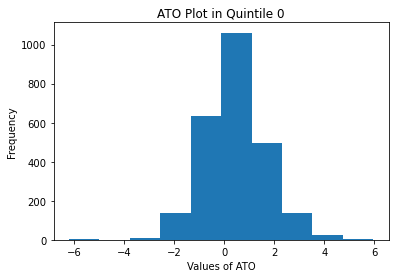

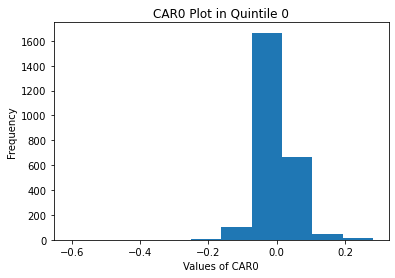

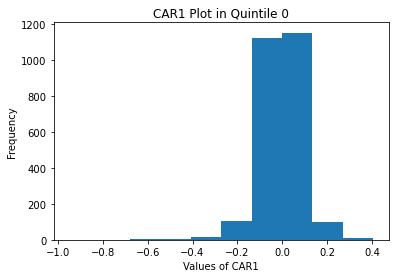

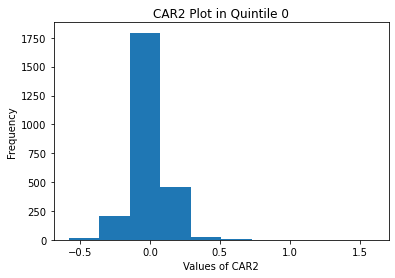

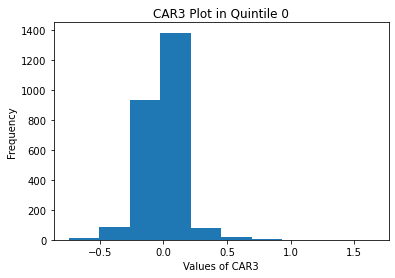

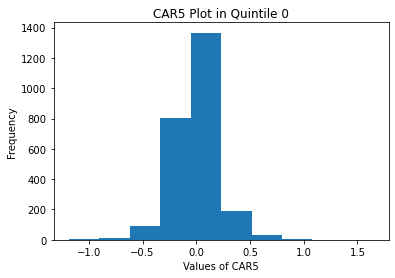

Quintile 1 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  504.000000  504.000000  504.000000  504.000000  504.000000  504.000000
mean     0.528953   -0.002298   -0.008084   -0.011024   -0.009635   -0.005262
std      1.233406    0.055068    0.083789    0.109492    0.135378    0.189611
min     -2.588056   -0.608473   -0.520856   -0.480733   -0.646712   -0.912755
25%     -0.289036   -0.020596   -0.043374   -0.064851   -0.079174   -0.102396
50%      0.462065   -0.001384   -0.004837   -0.008221   -0.009015   -0.007469
75%      1.226436    0.019512    0.037027    0.048123    0.061359    0.095042
max      5.961652    0.218145    0.336724    0.543610    0.591154    0.759426


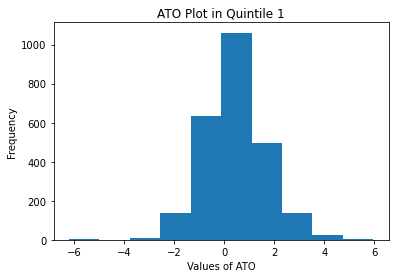

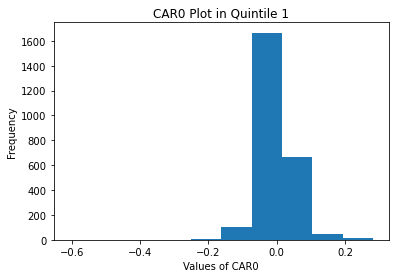

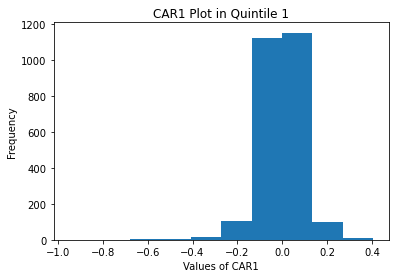

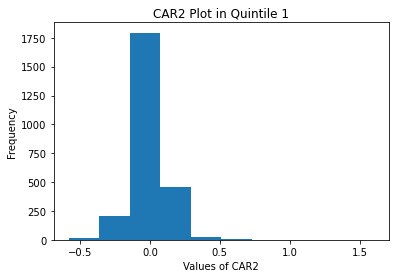

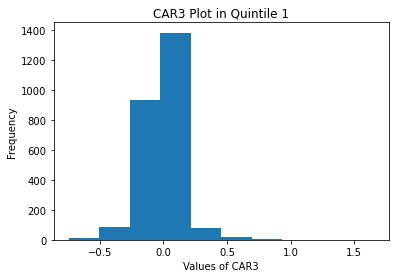

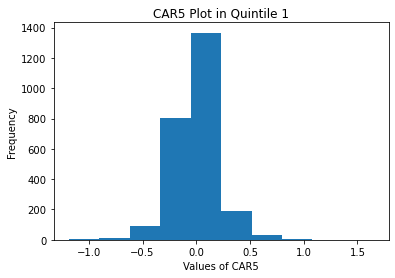

Quintile 2 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  499.000000  499.000000  499.000000  499.000000  499.000000  499.000000
mean     0.436337    0.001951    0.003263    0.005190    0.007741    0.011659
std      1.186179    0.047740    0.081729    0.115241    0.144459    0.206333
min     -2.924221   -0.203848   -0.332802   -0.415843   -0.588953   -1.185558
25%     -0.314857   -0.021433   -0.042636   -0.057438   -0.070038   -0.088198
50%      0.424209    0.000462    0.002436   -0.001414    0.003081   -0.000308
75%      1.162538    0.020699    0.041579    0.068878    0.080068    0.108951
max      4.209357    0.282731    0.344932    0.654366    0.744943    0.933842


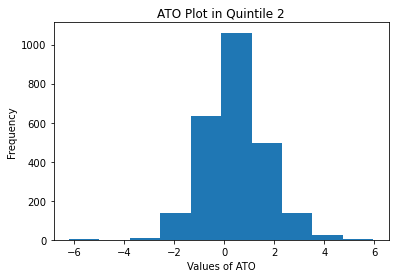

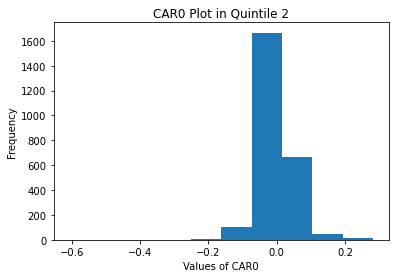

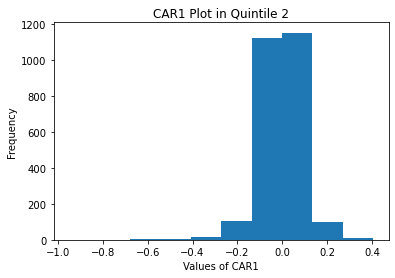

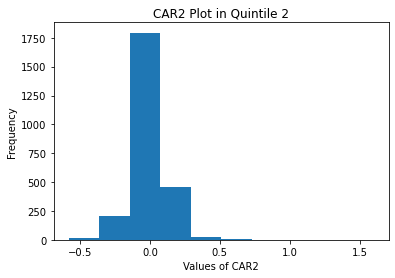

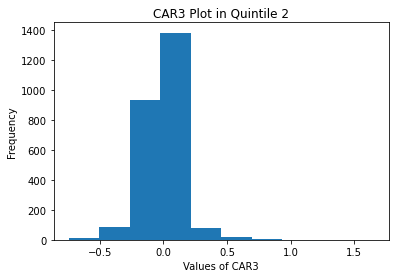

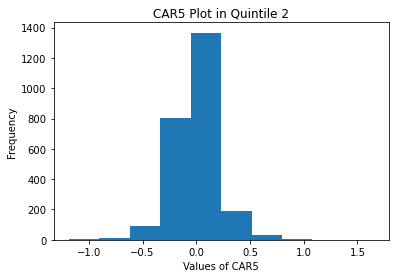

Quintile 3 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000
mean     0.428643   -0.001305   -0.004733   -0.005980   -0.003335   -0.000850
std      1.239393    0.052504    0.098540    0.146486    0.179046    0.231446
min     -6.216906   -0.254747   -0.581957   -0.579308   -0.646712   -0.912755
25%     -0.336893   -0.019792   -0.044635   -0.070619   -0.081337   -0.100239
50%      0.338615   -0.001557   -0.000366    0.001022    0.004578    0.006989
75%      1.077641    0.019117    0.040581    0.055585    0.071295    0.102789
max      4.303098    0.239341    0.405881    1.598387    1.648797    1.647928


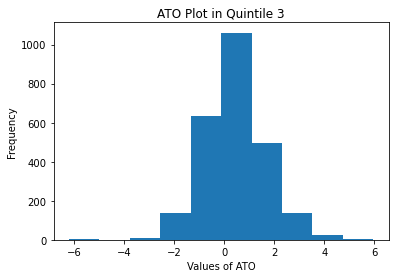

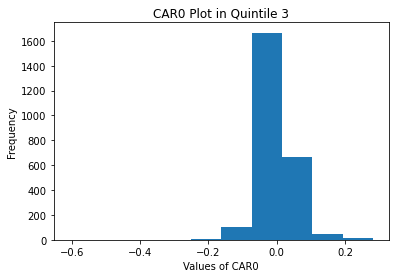

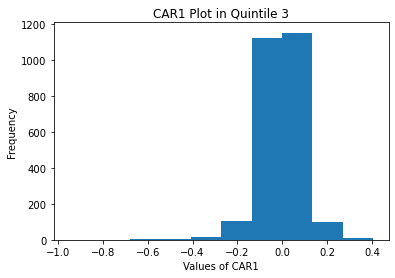

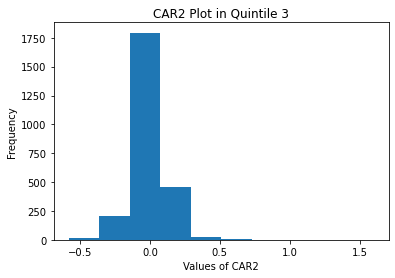

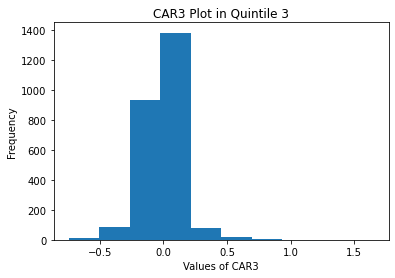

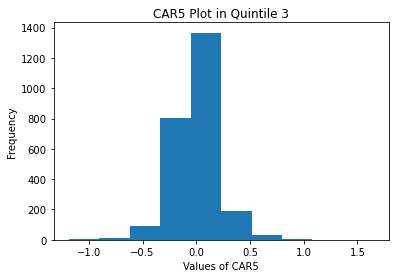

Quintile 4 Descriptive Stats: 
              ATO        CAR0        CAR1        CAR2        CAR3        CAR5
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000
mean     0.366370   -0.004782   -0.003245    0.000770   -0.004675   -0.005179
std      1.113789    0.051226    0.094918    0.114708    0.141596    0.192324
min     -4.022694   -0.412782   -0.951079   -0.579308   -0.742702   -0.912755
25%     -0.332487   -0.020805   -0.036685   -0.053360   -0.068842   -0.087244
50%      0.292591   -0.003174   -0.000093    0.006314    0.001641    0.001842
75%      0.985145    0.015445    0.037141    0.062010    0.060450    0.087254
max      4.845026    0.205504    0.243147    0.432751    0.495501    0.701030


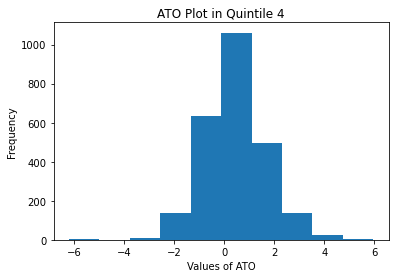

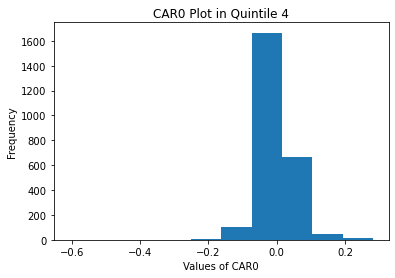

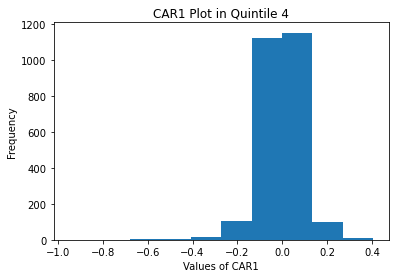

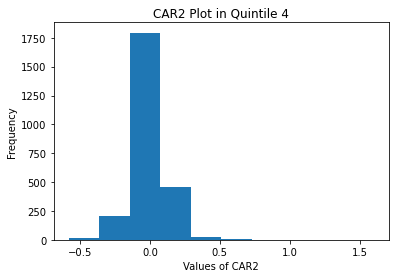

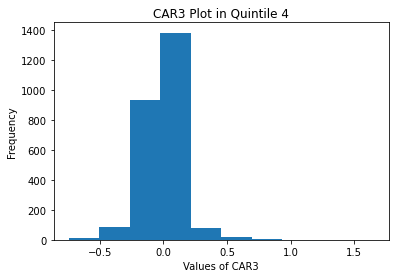

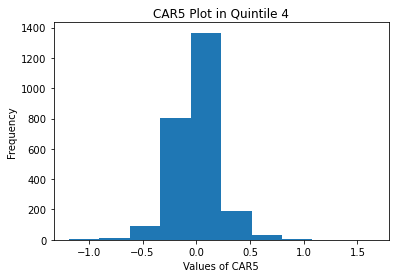

In [34]:
final['QUINTILE'] = pd.qcut(final['sentence_tone'], q=5, labels = False)
for i in range (0, 5):
    val = final.loc[final['QUINTILE'] == i]
    print('Quintile', i, 'Descriptive Stats: ')
    describeval = val[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
    print(describeval.describe())
    for j in vlist:
        plot = final[j].plot.hist()
        plt.xlabel('Values of ' + str(j))
        plt.title(str(j) + ' Plot in Quintile ' + str(i))
        plt.show()

Back to [Index](#Index)